In [1]:
import os
import time
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from network_files import MaskRCNN
from backbone import resnet50_fpn_backbone
from draw_box_utils import draw_objs
import cv2
from skimage.measure import find_contours
import skimage.io

In [2]:
def create_model(num_classes, box_thresh=0.5):
    backbone = resnet50_fpn_backbone()
    model = MaskRCNN(backbone,
                     num_classes=num_classes,
                     rpn_score_thresh=box_thresh,
                     box_score_thresh=box_thresh)

    return model

In [3]:
def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

In [26]:
num_classes = 1  # 不包含背景
box_thresh = 0.5
weights_path = "./save_weights/model_14.pth"
img_path = "./data/60_0_0_crop.tif"
label_json_path = "./coco91_indices.json"

In [27]:
# get devices
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [28]:
# create model
model = create_model(num_classes=num_classes + 1, box_thresh=box_thresh)

In [29]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [30]:
 # load train weights
assert os.path.exists(weights_path), "{} file dose not exist.".format(weights_path)
weights_dict = torch.load(weights_path, map_location='cpu')
weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
model.load_state_dict(weights_dict)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [31]:
 # read class_indict
assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
with open(label_json_path, 'r') as json_file:
    category_index = json.load(json_file)

In [32]:
 # load image
assert os.path.exists(img_path), f"{img_path} does not exits."
original_img = Image.open(img_path).convert('RGB')
or_img=skimage.io.imread(img_path)
padding_scale = 10
#or_img=cv2.copyMakeBorder(or_img, padding_scale,padding_scale,padding_scale,padding_scale, cv2.BORDER_CONSTANT, value=[255,255,255])

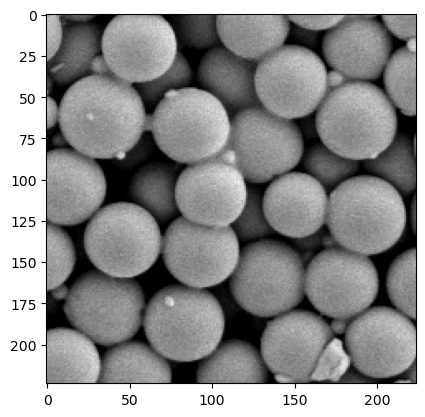

In [33]:
plt.imshow(or_img)

In [34]:
model.eval();  # 进入验证模式

In [35]:
def get_mask_contours(mask):
    #mask = masks[:, :, i]
    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    contours_mask = []
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        contours_mask.append(np.array(verts, np.int32))
    return contours_mask

inference+NMS time: 0.031147241592407227
47
1388.3040827978464
777.5852460522729
412.8370313481937
586.5912508392066
739.6176760459202
1434.1096608999796
1601.356009032439
477.5589482177011
1566.0980936714695
1698.3956461081398
865.2555887219569
185.7063529727046
1717.2232449010771
1234.1635966450776
1438.7817223154707
1696.5321561265155
1509.5537810054957
1111.3808431363432
1263.6074862974929
1955.720833608546
904.9681959197542
1441.7124331641826
565.2873207277735
1410.8431002841098
207.83529848994522
381.3465459959116
1335.7141397146916
212.58589260353438
39.586394151910326
520.0391275882721
711.3030071317253
1537.8579307070322
399.3392432705732
1144.218231933697
1413.1298331733997
630.4854522771784
83.79941048211549
94.41412598558236
370.7915127624292
55.85205391148702
74.95590063365125
838.1498526833893
176.29421627415286
31.02416167058982
29.367853980409564
356.0752753181514
33.81086571654305


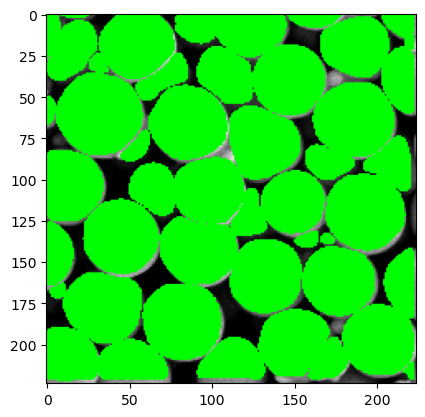

In [36]:
 with torch.no_grad():
        # init
        # from pil image to tensor, do not normalize image
        data_transform = transforms.Compose([transforms.ToTensor()])
        img = data_transform(original_img)
        # expand batch dimension
        img = torch.unsqueeze(img, dim=0)
        img_height, img_width = img.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)

        t_start = time_synchronized()
        predictions = model(img.to(device))[0]
        t_end = time_synchronized()
        print("inference+NMS time: {}".format(t_end - t_start))

        predict_boxes = predictions["boxes"].to("cpu").numpy()
        predict_classes = predictions["labels"].to("cpu").numpy()
        predict_scores = predictions["scores"].to("cpu").numpy()
        predict_mask = predictions["masks"].to("cpu").numpy()
        predict_mask = np.squeeze(predict_mask, axis=1)  # [batch, 1, h, w] -> [batch, h, w]
        x = len(predict_boxes)
        print(x)
        a = 0
        for i in range(0,x):
            mask=predict_mask[i]
            #if mask[:,-1:].any()==0 and mask[:,0:1].any()==0 and mask[0:1,:].any()==0 and mask[-1:,:].any()==0:
            #print(mask,mask.shape)
#             print(predict_mask[i].shape)
            #print(mask)
            #contours_mask = []
            #mask = np.concatenate(mask, axis=0)
            contours=find_contours(mask,0.8)
            #print(contours)

            contours_mask = []
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                contours_mask.append(np.array(verts, np.int32))
                #print(contours_mask)

            contours = np.array(contours[0], dtype=np.float32)
            #area_total = []
            #for j in range(len(contours)):
            #    contours = np.array(contours[j], dtype=np.float32)
            #print(contours)
            #cv2.polylines(or_img, contours, True, (0,255,0), 1)
            #    area_px = cv2.contourArea(contours)
            #    area_total.append(area_px)
            #print(contours)
            #area_px = area_total.sum()

            area_px = cv2.contourArea(contours)
            print(area_px)
            a+=area_px
            img=cv2.drawContours(or_img, contours_mask, -1, (0, 255, 0), -1)
            cv2.imwrite(r"./result2/result{}_{}_{}.jpg".format(666,3,235),img)
            plt.imshow(img)
        #print(a)
        #avg_area=a/x
        #print(avg_area)
        if len(predict_boxes) == 0:
            print("没有检测到任何目标!")

        plot_img = draw_objs(original_img,
                             boxes=predict_boxes,
                             classes=predict_classes,
                             scores=predict_scores,
                             masks=predict_mask,
                             category_index=category_index,
                             line_thickness=3,
                             font='arial.ttf',
                             font_size=5)
        #cv2.imwrite(r"./result2/result{}_{}_{}.jpg".format(60,0,212),img)
        #print(plot_img)
        #plt.imshow(plot_img)
        #plt.show()
        # 保存预测的图片结果
        plot_img.save("test_result.jpg")
        #padded_mask = np.zeros(
        #(mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        #padded_mask[1:-1, 1:-1] = mask
        #print(padded_mask)
        #plt.imshow(padded_mask)
        #int(predict_mask[0])
        #countours=get_mask_contours(predict_mask[0])
        #thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, anchor=(2, 0), iterations=5)
        
        #contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
        #cv2.drawContours(img,contours,-1,(0,0,255),3)  
        #cv2.imshow("img", img)  
        #cv2.waitKey(0) 

        #plt.imshow(thresh)
        #plt.subplot(4, 4,   1)
        #plt.imshow(mask1)
        #plt.show()       

In [6]:
A1 = 0
N1 = 0
p = 4
O = 6
for k in range(0, 1):
    for w in range(0,1):
        num_classes = 1  # 不包含背景
        box_thresh = 0.5
        weights_path = "./save_weights/model_14.pth"
        #img_path = "./data/test/9_5_3_crop.jpg"
        label_json_path = "./coco91_indices.json"
        # get devices
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #print("using {} device.".format(device))
        # create model
        model = create_model(num_classes=num_classes + 1, box_thresh=box_thresh)
        # load train weights
        assert os.path.exists(weights_path), "{} file dose not exist.".format(weights_path)
        weights_dict = torch.load(weights_path, map_location='cpu')
        weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
        model.load_state_dict(weights_dict)
        model.to(device)
        # read class_indict
        assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
        with open(label_json_path, 'r') as json_file:
            category_index = json.load(json_file)
        # load image
        #assert os.path.exists(img_path), f"{img_path} does not exits."
        #original_img = Image.open(img_path).convert('RGB')
        #or_img=skimage.io.imread(img_path)
        original_img = cv2.imread(r"./data/1622/{}_{}_{}_crop.png".format(9,0,2))
        #original_img = cv2.imread(r"./TL/60_0_2_crop.tif")
        or_img = original_img
        #padding_scale = 10
        #or_img=cv2.copyMakeBorder(or_img, padding_scale,padding_scale,padding_scale,padding_scale, cv2.BORDER_CONSTANT, value=[255,255,255])
        model.eval()
        with torch.no_grad():
            # init
            # from pil image to tensor, do not normalize image
            data_transform = transforms.Compose([transforms.ToTensor()])
            img = data_transform(original_img)
            # expand batch dimension
            img = torch.unsqueeze(img, dim=0)
            img_height, img_width = img.shape[-2:]
            init_img = torch.zeros((1, 3, img_height, img_width), device=device)
            model(init_img)

            t_start = time_synchronized()
            predictions = model(img.to(device))[0]
            t_end = time_synchronized()
            #print("inference+NMS time: {}".format(t_end - t_start))

            predict_boxes = predictions["boxes"].to("cpu").numpy()
            predict_classes = predictions["labels"].to("cpu").numpy()
            predict_scores = predictions["scores"].to("cpu").numpy()
            predict_mask = predictions["masks"].to("cpu").numpy()
            predict_mask = np.squeeze(predict_mask, axis=1)  # [batch, 1, h, w] -> [batch, h, w]
            x = len(predict_boxes)
            #print(x)
            a1 = 0
            b1 = 0
            for i in range(0,x):
                mask=predict_mask[i]
                if mask[:,-1:].any()==0 and mask[:,0:1].any()==0 and mask[0:1,:].any()==0 and mask[-1:,:].any()==0:
                    contours1=find_contours(mask,0.6)
                    contours_mask1 = []
                    for verts in contours1:
                        # Subtract the padding and flip (y, x) to (x, y)
                        verts = np.fliplr(verts) - 1
                        contours_mask1.append(np.array(verts, np.int32))
                    contours1 = np.array(contours1[0], dtype=np.float32)
                    area_px = cv2.contourArea(contours1)
                    a1+=area_px
                    b1+=1
                    img=cv2.drawContours(or_img, contours_mask1, -1, (0,0,255), -1)
                    #cv2.imwrite(r"./result2/result{}_{}_{}.jpg".format(90,0,2),img)
                else:
                    contours2=find_contours(mask,0.6)
                    contours_mask2 = []
                    for verts in contours2:
                        # Subtract the padding and flip (y, x) to (x, y)
                        verts = np.fliplr(verts) - 1
                        contours_mask2.append(np.array(verts, np.int32))
                    contours2 = np.array(contours2[0], dtype=np.float32)
                    area_px = cv2.contourArea(contours2)
                    img=cv2.drawContours(or_img, contours_mask2, -1, (0,255,0), -1)
                cv2.imwrite(r"./result2/result{}_{}_{}.jpg".format(90,0,4),img)
            A1+=a1
            N1+=b1
            if len(predict_boxes) == 0:
                print("没有检测到任何目标!")
#all_avg = all_avg/p/O
#all_avg = (A1)/(N1)
#print(all_avg)

In [464]:
 with torch.no_grad():
        # init
        img_height, img_width = img.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)

        t_start = time_synchronized()
        predictions = model(img.to(device))[0]
        t_end = time_synchronized()
        print("inference+NMS time: {}".format(t_end - t_start))

        predict_boxes = predictions["boxes"].to("cpu").numpy()
        predict_classes = predictions["labels"].to("cpu").numpy()
        predict_scores = predictions["scores"].to("cpu").numpy()
        predict_mask = predictions["masks"].to("cpu").numpy()
       
        predict_mask = np.squeeze(predict_mask, axis=1)  # [batch, 1, h, w] -> [batch, h, w]
        

        if len(predict_boxes) == 0:
            print("没有检测到任何目标!")

        plot_img = draw_objs(original_img,
                             boxes=predict_boxes,
                             classes=predict_classes,
                             scores=predict_scores,
                             masks=predict_mask,
                             category_index=category_index,
                             line_thickness=3,
                             font='arial.ttf',
                             font_size=5)
        print(plot_img)
        plt.imshow(plot_img)
        plt.show()
        # 保存预测的图片结果
        plot_img.save("test_result.jpg")

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
image=original_img
boxes=predict_boxes
classes=predict_classes
scores=predict_scores
masks=predict_mask
category_index=category_index
line_thickness=3
font='arial.ttf'
font_size=2

In [43]:
thresh: float = 0.7
alpha: float = 0.5
np_image = np.array(image)
masks = np.where(masks > thresh, True, False)

# colors = np.array(colors)
img_to_draw = np.copy(np_image)
# TODO: There might be a way to vectorize this
for mask, color in zip(masks, colors):
    img_to_draw[mask] = color

out = np_image * (1 - alpha) + img_to_draw * alpha

ValueError: invalid literal for int() with base 10: 'g'

[[[174  15]]

 [[175  14]]

 [[176  15]]

 [[176  22]]

 [[174  24]]

 [[171  24]]

 [[171  28]]

 [[169  30]]

 [[168  30]]

 [[167  29]]

 [[167  28]]

 [[169  26]]

 [[169  25]]

 [[168  25]]

 [[167  24]]

 [[167  16]]

 [[168  15]]] (17, 1, 2) 34
96.5


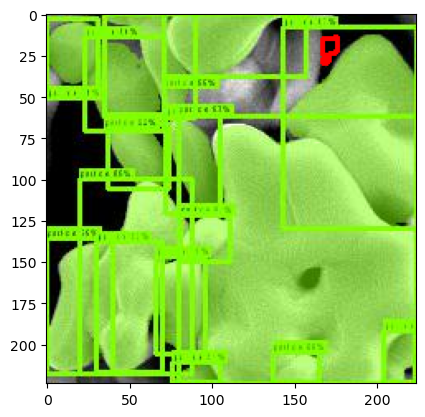

In [105]:
p='./test_result.jpg'
img = cv2.imread(p)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 0, 255, 0)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[44]
img_color1 = np.copy(img)
img_color2 = np.copy(img)

cv2.drawContours(img_color1, [cnt], 0, (0,0,255), 2)

print(cnt, cnt.shape, cnt.size)
area = cv2.contourArea(cnt)
print(area)

plt.imshow(img_color1[:,:,::-1])
plt.show()

In [68]:
p='./test/9_3_2_crop.jpg'
img = cv2.imread(p)

In [69]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

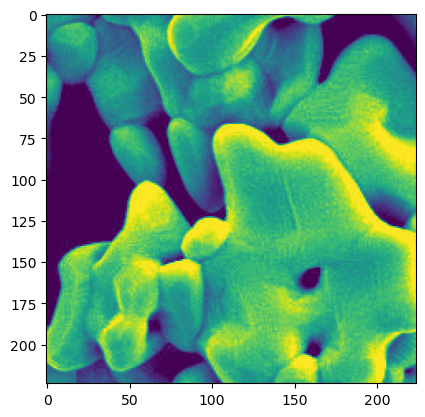

In [70]:
plt.imshow(img_gray)

In [71]:
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [72]:
print(ret)

105.0


In [73]:
print(thresh)

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


[[[19  0]]

 [[20  0]]

 [[21  1]]

 ...

 [[36  5]]

 [[33  2]]

 [[33  0]]] (531, 1, 2) 1062
7424.0


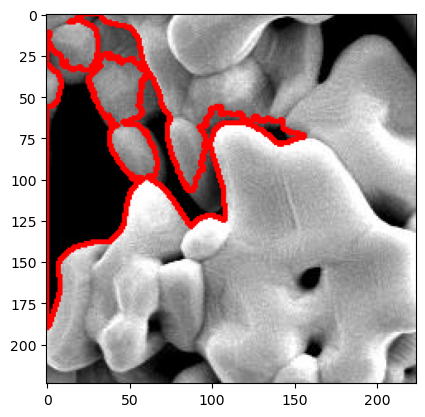

In [104]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[44]
img_color1 = np.copy(img)
img_color2 = np.copy(img)

cv2.drawContours(img_color1, [cnt], 0, (0,0,255), 2)

print(cnt, cnt.shape, cnt.size)
area = cv2.contourArea(cnt)
print(area)

plt.imshow(img_color1[:,:,::-1])
plt.show()

In [42]:
p='./test_result.jpg'
img = cv2.imread(p)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]
img_color1 = np.copy(img)
img_color2 = np.copy(img)

cv2.drawContours(img_color1, [cnt], 0, (0,0,255), 2)

array([[[143, 127,  98],
        [148, 131, 110],
        [149, 130, 127],
        ...,
        [ 44,  72,  79],
        [ 90,  68,  86],
        [128,  82, 104]],

       [[ 98, 158,  97],
        [105, 163, 109],
        [104, 155, 118],
        ...,
        [ 43,  71,  72],
        [ 84,  67,  78],
        [119,  78,  93]],

       [[ 29, 247, 117],
        [ 45, 254, 134],
        [ 53, 242, 143],
        ...,
        [ 46,  75,  66],
        [ 86,  74,  74],
        [118,  87,  90]],

       ...,

       [[121, 117, 112],
        [124, 121, 117],
        [115, 115, 115],
        ...,
        [ 19, 150,  77],
        [ 36, 230, 124],
        [ 28, 253, 131]],

       [[151, 138, 136],
        [136, 131, 130],
        [124, 132, 132],
        ...,
        [ 22, 233, 137],
        [  7, 255, 131],
        [  0, 255, 117]],

       [[134, 116, 117],
        [115, 107, 108],
        [117, 129, 131],
        ...,
        [  0, 239, 133],
        [  0, 255, 127],
        [  0, 255, 119]]

In [60]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [61]:
print(contours)

[array([[[ 78, 220]]], dtype=int32), array([[[ 48, 220]],

       [[ 50, 222]],

       [[ 49, 223]],

       [[ 48, 223]],

       [[ 74, 223]],

       [[ 74, 220]]], dtype=int32), array([[[ 17, 220]],

       [[ 17, 222]],

       [[ 16, 223]],

       [[ 17, 222]],

       [[ 18, 223]],

       [[ 45, 223]],

       [[ 43, 221]],

       [[ 43, 220]]], dtype=int32), array([[[ 13, 220]],

       [[ 14, 220]],

       [[ 15, 221]],

       [[ 15, 220]]], dtype=int32), array([[[ 17, 216]],

       [[ 18, 216]]], dtype=int32), array([[[  6, 216]]], dtype=int32), array([[[221, 214]],

       [[220, 215]],

       [[218, 215]],

       [[217, 216]],

       [[217, 219]],

       [[219, 221]],

       [[220, 220]],

       [[221, 220]]], dtype=int32), array([[[  2, 214]],

       [[  2, 216]],

       [[  4, 216]]], dtype=int32), array([[[ 82, 213]],

       [[ 82, 216]],

       [[ 83, 215]],

       [[ 84, 215]],

       [[ 85, 214]],

       [[ 86, 214]],

       [[ 86, 213]]], dtype=i

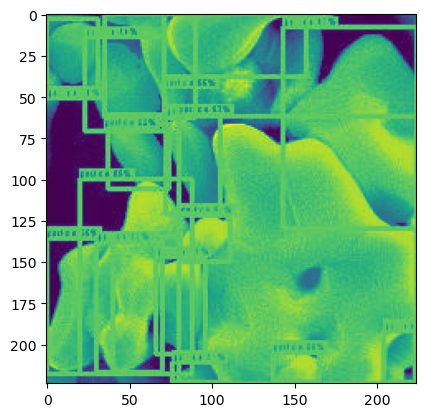

In [105]:
p='./test_result.jpg'
img = cv2.imread(p)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)